In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import f1_score, accuracy_score

def create_axes_grid(numplots_x, numplots_y, plotsize_x=6, plotsize_y=3):
    fig, axes = plt.subplots(numplots_y, numplots_x)
    fig.set_size_inches(plotsize_x * numplots_x, plotsize_y * numplots_y)
    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    return fig, axes
    
def set_axes(axes, use_grid=True, x_val = [0,100,10,5], y_val = [-50,50,10,5]):
    axes.grid(use_grid)
    axes.tick_params(which='both', direction='inout', top=True, right=True, labelbottom=True, labelleft=True)
    axes.set_xlim(x_val[0], x_val[1])
    axes.set_ylim(y_val[0], y_val[1])
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[2] + 1).astype(int)))
    axes.set_xticks(np.linspace(x_val[0], x_val[1], np.around((x_val[1] - x_val[0]) / x_val[3] + 1).astype(int)), minor=True)
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[2] + 1).astype(int)))
    axes.set_yticks(np.linspace(y_val[0], y_val[1], np.around((y_val[1] - y_val[0]) / y_val[3] + 1).astype(int)), minor=True)

In [44]:
# def viterbi(p_trans, p_signal, p_in, signal):
# 
#     offset = 10**(-20) # added to values to avoid problems with log2(0)
# 
#     p_trans_tlog  = np.transpose(np.log2(p_trans  + offset)) # p_trans, logarithm + transposed
#     p_signal_tlog = np.transpose(np.log2(p_signal + offset)) # p_signal, logarithm + transposed
#     p_in_log      =              np.log2(p_in     + offset)  # p_in, logarithm
# 
#     p_state_log = [ p_in_log + p_signal_tlog[signal[0]] ] # initial state probabilities for signal element 0 
# 
#     for s in signal[1:]:
#         p_state_log.append(np.max(p_state_log[-1] + p_trans_tlog, axis=1) + p_signal_tlog[s]) # the Viterbi algorithm
# 
#     states = np.argmax(p_state_log, axis=1) # finding the most probable states
#     
#     return states

def viterbi(p_trans, p_signal, p_in, signal):
    offset = 10 ** (-20)  # added to values to avoid problems with log2(0)

    p_trans_tlog = np.transpose(np.log2(p_trans + offset))  # p_trans, logarithm + transposed
    p_signal_tlog = np.transpose(np.log2(p_signal + offset))  # p_signal, logarithm + transposed
    p_in_log = np.log2(p_in + offset)  # p_in, logarithm

    p_state_log = [p_in_log + p_signal_tlog[signal[0]]]  # initial state probabilities for signal element 0
    p_max_pre = []

    for s in signal[1:]:
        p_max_pre.append(np.argmax(p_state_log[-1] + p_trans_tlog, axis=1))
        p_state_log.append(np.max(p_state_log[-1] + p_trans_tlog, axis=1) + p_signal_tlog[s])  # the Viterbi algorithm

    max_states = np.argmax(p_state_log, axis=1)  # finding the most probable states
    last_state = max_states[-1]
    # last_state = 6

    states = []
    states.insert(0, last_state)
    for i in range(len(max_states) - 1):
        states.insert(0, p_max_pre[-1 - i][states[0]])

    return states

In [45]:
df_train = pd.read_csv("data/train.csv")
signal = df_train['signal'].values[2000000:2500000]
true_state = df_train['open_channels'].values[2000000:2500000]

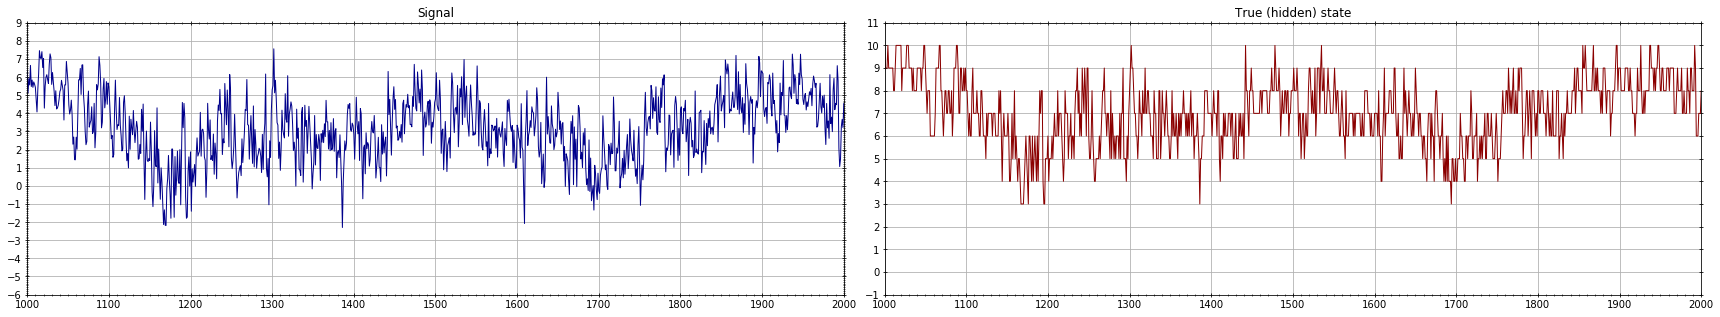

In [46]:
fig, axes = create_axes_grid(2,1,15,5)

set_axes(axes[0], x_val=[1000, 2000, 100, 10], y_val=[-6,9,1,0.1])
axes[0].set_title('Signal')
axes[0].plot(signal, linewidth=1, color='darkblue');

set_axes(axes[1], x_val=[1000, 2000, 100, 10], y_val=[-1,11,1,1])
axes[1].set_title('True (hidden) state')
axes[1].plot(true_state, linewidth=1, color='darkred');

In [47]:
def calc_markov_p_trans(states):
    max_state = np.max(states)
    states_next = np.roll(states, -1)
    matrix = []
    for i in range(max_state + 1):
        current_row = np.histogram(states_next[states == i], bins=np.arange(max_state + 2))[0]
        if np.sum(current_row) == 0: # if a state doesn't appear in states...
            current_row = np.ones(max_state + 1) / (max_state + 1) # ...use uniform probability
        else:
            current_row = current_row / np.sum(current_row) # normalize to 1
        matrix.append(current_row)
    return np.array(matrix)

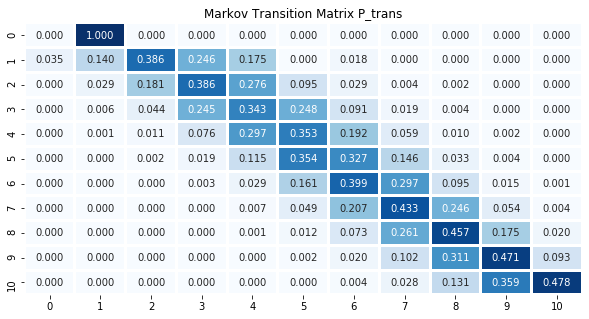

In [48]:
p_trans = calc_markov_p_trans(true_state)

fig, axes = create_axes_grid(1,1,10,5)
axes.set_title('Markov Transition Matrix P_trans')
sns.heatmap(
    p_trans,
    annot=True, fmt='.3f', cmap='Blues', cbar=False,
    ax=axes, vmin=0, vmax=0.5, linewidths=2);

In [49]:
def calc_markov_p_signal(state, signal, num_bins = 1000):
    states_range = np.arange(state.min(), state.max() + 1)
    signal_bins = np.linspace(signal.min(), signal.max(), num_bins + 1)
    p_signal = np.array([ np.histogram(signal[state == s], bins=signal_bins)[0] for s in states_range ])
    p_signal = np.array([ p / np.sum(p) for p in p_signal ]) # normalize to 1
    return p_signal, signal_bins

In [50]:
p_signal, signal_bins = calc_markov_p_signal(true_state, signal)

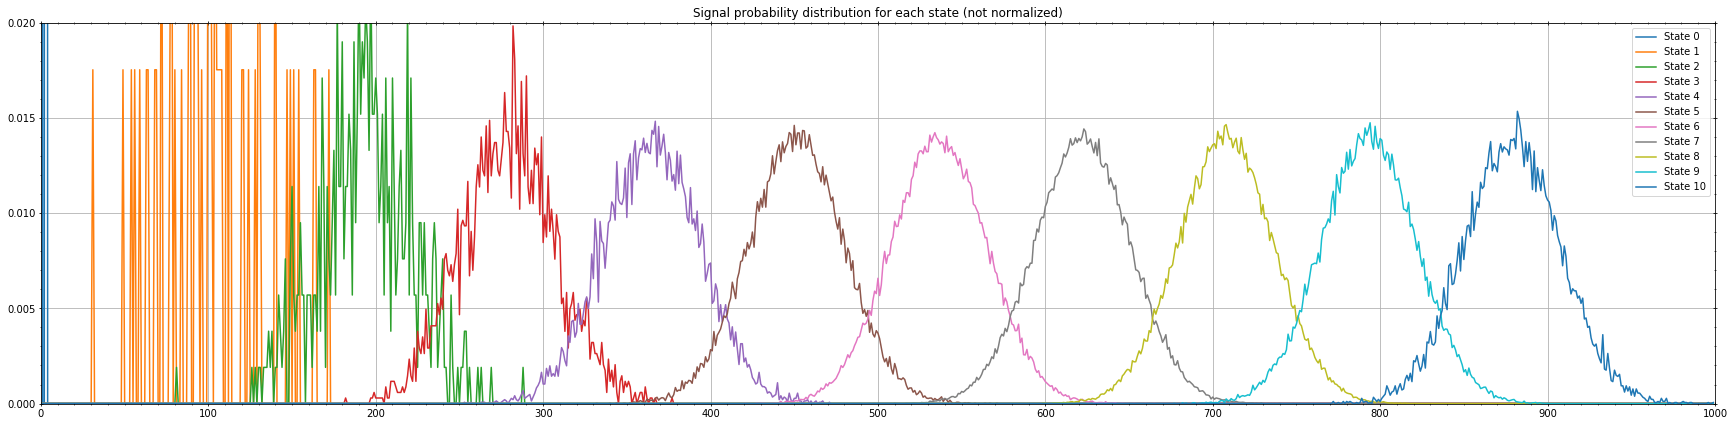

In [51]:
fig, axes = create_axes_grid(1,1,30,7)
set_axes(axes, x_val=[0, 1000, 100, 10], y_val=[0,0.02,0.005,0.001])
axes.set_title('Signal probability distribution for each state (not normalized)')
for s,p in enumerate(p_signal):
    axes.plot(p, label="State "+str(s));
axes.legend();

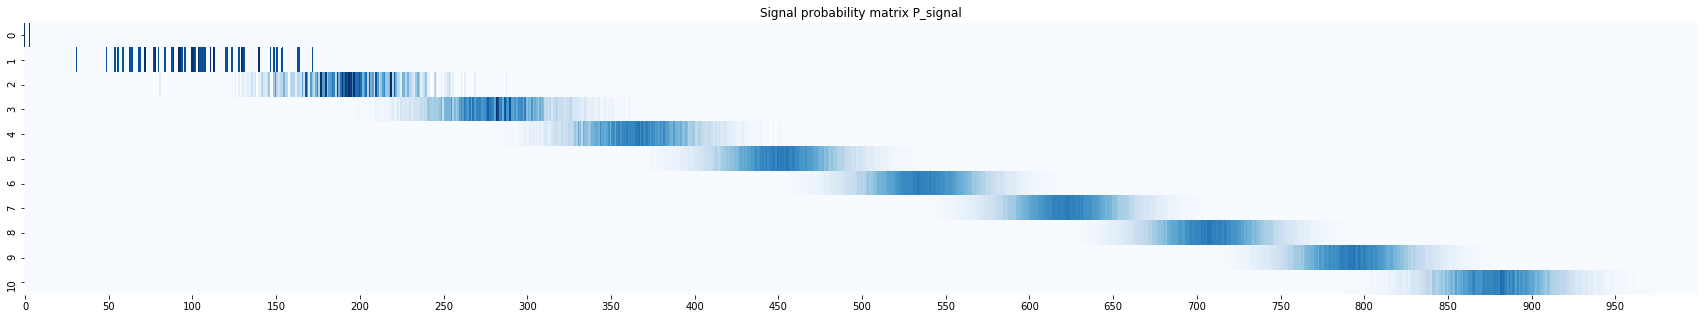

In [52]:
fig, axes = create_axes_grid(1,1,30,5)
axes.set_title('Signal probability matrix P_signal')
sns.heatmap(
    p_signal,
    annot=False, cmap='Blues', cbar=False, xticklabels=50,
    ax=axes, vmin=0, vmax=0.02);

In [53]:
def digitize_signal(signal, signal_bins):
    signal_dig = np.digitize(signal, bins=signal_bins) - 1 # these -1 and -2 are necessary because of the way...
    signal_dig = np.minimum(signal_dig, len(signal_bins) - 2) # ... numpy.digitize works
    return signal_dig

In [54]:
signal_dig = digitize_signal(signal, signal_bins)
print ("Signal bin values:", signal_dig)

Signal bin values: [896 872 883 ... 531 658 600]


In [55]:
p_in = np.ones(len(p_trans)) / len(p_trans)
print("Initial probability p_in =", p_in)

Initial probability p_in = [0.09090909 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909
 0.09090909 0.09090909 0.09090909 0.09090909 0.09090909]


In [56]:
viterbi_state = viterbi(p_trans, p_signal, p_in, signal_dig)
print("State sequence as predicted by Viterbi algorithm :", viterbi_state)


State sequence as predicted by Viterbi algorithm : [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 9, 8, 9, 9, 10, 10, 10, 9, 9, 10, 10, 10, 10, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 9, 9, 9, 9, 10, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 9, 9, 9, 9, 10, 10, 10, 10, 10, 9, 9,

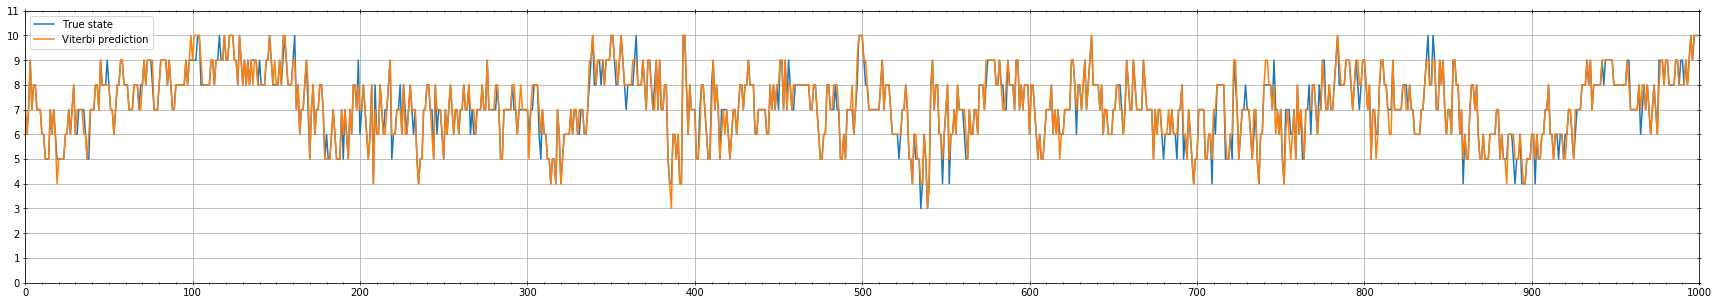

In [57]:
fig, axes = create_axes_grid(1,1,30,5)
set_axes(axes, x_val=[0,1000,100,10], y_val=[0,11,1,1])

axes.plot(true_state[10000:11000], label="True state")
axes.plot(viterbi_state[10000:11000], label="Viterbi prediction")
axes.legend();

In [58]:
print("Accuracy =", accuracy_score(y_pred=viterbi_state, y_true=true_state))
print("F1 macro =", f1_score(y_pred=viterbi_state, y_true=true_state, average='macro'))

Accuracy = 0.88586
F1 macro = 0.8924839794715961


In [34]:
df_train_clean = pd.read_csv("data/train_clean.csv")
df_test_clean = pd.read_csv("data/test_clean.csv")


In [39]:
with np.load('data/train_detrend.npz', allow_pickle=True) as data:
    train_signal = data['train_signal']
    train_opchan = data['train_opench']
    train_groups = data['train_groups']
    
with np.load('data/test_detrend.npz', allow_pickle=True) as data:
    test_signal = data['test_signal']
    test_groups = data['test_groups']

In [42]:
%%time

train_group_ids = [ [0,1,2], [3,7], [4,8], [6,9], [5,10]  ]
test_group_ids  = [ [0,3,8,10,11], [4], [1,9], [2,6], [5,7] ]
test_y_pred = [None] * 12

for train_groups, test_groups in zip(train_group_ids, test_group_ids):
    
    print("train_groups :", train_groups, ", test_groups :", test_groups)

    signal_train     = np.concatenate(train_signal[train_groups])
    true_state_train = np.concatenate(train_opchan[train_groups])
    
    p_trans               = calc_markov_p_trans(true_state_train)
    p_signal, signal_bins = calc_markov_p_signal(true_state_train, signal_train)
    p_in = np.ones(len(p_trans)) / len(p_trans)

    for test_grp in test_groups:
        signal_dig = digitize_signal(test_signal[test_grp], signal_bins)
        test_y_pred[test_grp] = viterbi(p_trans, p_signal, p_in, signal_dig)
        
test_y_pred = np.concatenate(test_y_pred)

train_groups : [0, 1, 2] , test_groups : [0, 3, 8, 10, 11]


IndexError: index 6 is out of bounds for axis 0 with size 2

In [ ]:
df_subm = pd.read_csv("data/sample_submission.csv")
df_subm['open_channels'] = test_y_pred
df_subm.to_csv("viterbi.csv", float_format='%.4f', index=False)
